Dataset loader, preprocess

Label Mapping: {'(': 0, ')': 1, '+': 2, ',': 3, '-': 4, '0': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '9': 14, '=': 15, 'T': 16, 'X': 17, 'cos': 18, 'e': 19, 'f': 20, 'forward_slash': 21, 'i': 22, 'phi': 23, 'pi': 24, 'sin': 25, 'sum': 26, 'tan': 27, 'theta': 28, 'times': 29, 'w': 30, 'y': 31, 'z': 32}
Training set size: 193105
Validation set size: 41379
Test set size: 41381


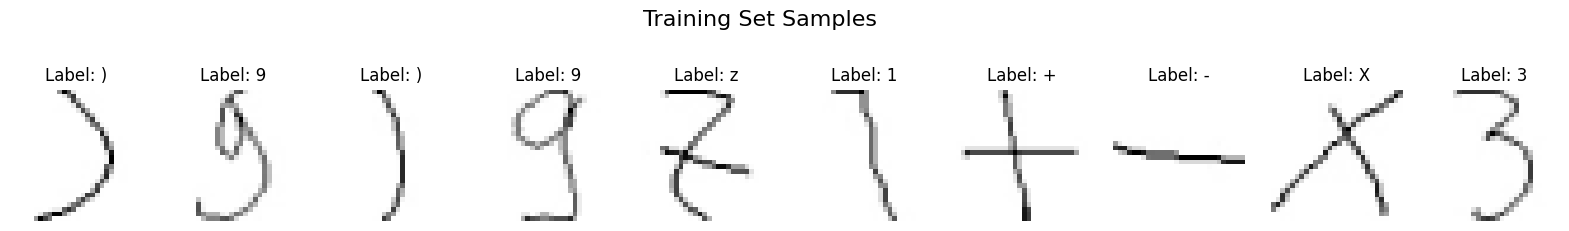

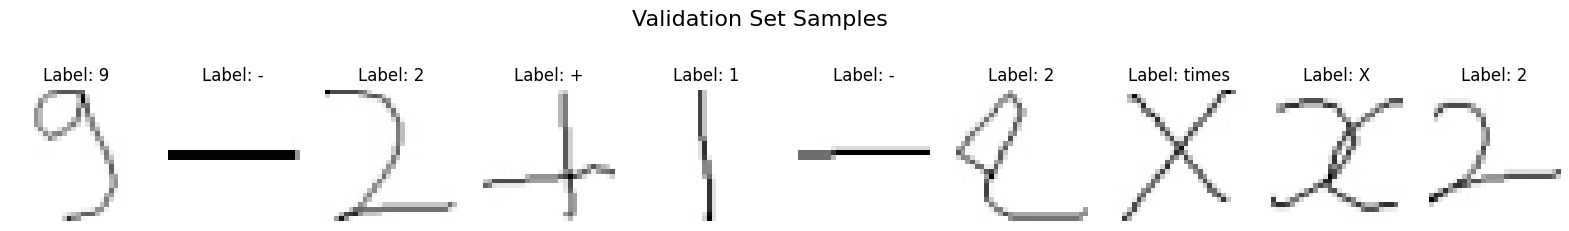

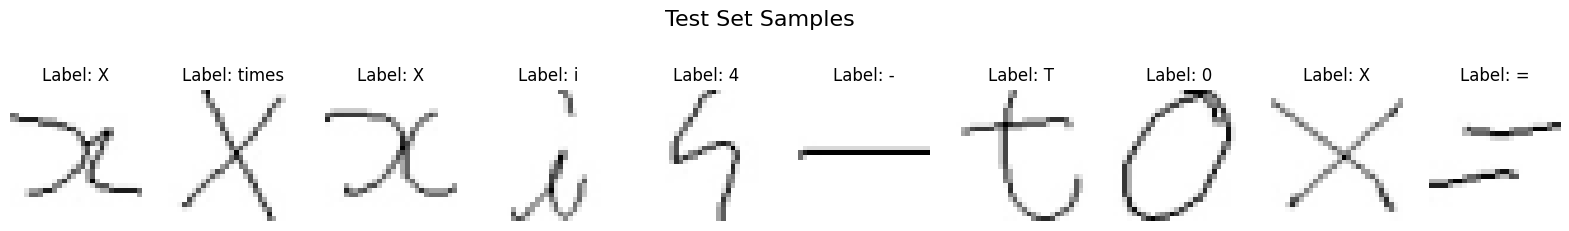

In [3]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),  # Resize to 28x28
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to mean 0, std 1
])

# Path to dataset (update with your actual dataset folder path)
dataset_path = "D:/pynq/FinalProject/dataset"

# Load dataset using ImageFolder
dataset = ImageFolder(root=dataset_path, transform=transform)
int_to_char = {v: k for k, v in dataset.class_to_idx.items()}

# Create a mapping for labels
label_mapping = dataset.class_to_idx
print("Label Mapping:", label_mapping)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
total_size = len(dataset)
train_size = int(total_size * train_ratio)
val_size = int(total_size * val_ratio)
test_size = total_size - train_size - val_size  # Remaining samples for test set

torch.manual_seed(42)
# Split the dataset
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Print the number of items in each split
print("Training set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

# Create DataLoaders for each set
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Function to display 10 samples from any DataLoader
def show_samples(dataloader, title="Samples", dataset=dataset):
    class_names = dataset.classes  # Get the class names from ImageFolder
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, 10, figsize=(20, 3))
    fig.suptitle(title, fontsize=16)
    for i in range(10):
        ax = axes[i]
        ax.imshow(images[i].squeeze().numpy(), cmap='gray')
        ax.set_title(f"Label: {class_names[labels[i]]}")  # Map the numeric label to the class name
        ax.axis('off')
    plt.show()

# Show samples from each set
show_samples(train_loader, "Training Set Samples")
show_samples(val_loader, "Validation Set Samples")
show_samples(test_loader, "Test Set Samples")


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.quantization as quant

# Define LeNet5 model
class LeNet5(nn.Module):
    def __init__(self, num_classes=33):  # Adjust according to your dataset
        super(LeNet5, self).__init__()
        self.quant = torch.ao.quantization.QuantStub()  # QuantStub
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.reshape(-1, 16 * 5 * 5)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        x = self.dequant(x)
        return x

# Function to save the model and labels
def save_model_and_labels(model, filepath, labels_mapping):
    torch.save({
        'model_state_dict': model.state_dict(),
        'labels_mapping': labels_mapping
    }, filepath)
    print(f"Model and labels saved to {filepath}")

# Function to evaluate the model
def evaluate_model(model, dataloader, criterion, device, desc="Evaluating"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    progress_bar = tqdm(dataloader, desc=desc)
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# Training and validation loop
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train for one epoch
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        progress_bar = tqdm(train_loader, desc="Training")
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total

        # Evaluate on the validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device, desc="Validating")

        # Print metrics
        print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Log metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Step the scheduler
        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies

# Initialize and prepare the model
device = torch.device('cpu')
model = LeNet5(num_classes=33)
model.eval()

# Set quantization backend and QConfig
torch.backends.quantized.engine = 'x86'
custom_qconfig = quant.QConfig(
    activation=quant.FakeQuantize.with_args(
        observer=quant.MinMaxObserver, quant_min=0, quant_max=255,
        dtype=torch.quint8, qscheme=torch.per_tensor_affine
    ),
    weight=quant.FakeQuantize.with_args(
        observer=quant.MinMaxObserver, quant_min=-128, quant_max=127,
        dtype=torch.qint8, qscheme=torch.per_tensor_symmetric
    )
)
model.qconfig = custom_qconfig

# Fuse and prepare for QAT
model_fused = torch.ao.quantization.fuse_modules(
    model, [['conv1', 'relu1'], ['conv2', 'relu2'], ['fc1', 'relu3'], ['fc2', 'relu4']]
)
model_prepared = torch.ao.quantization.prepare_qat(model_fused.train(), inplace=True)
model_prepared.to(device)

# Define training components
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_prepared.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Train and validate
num_epochs = 15
train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model_prepared, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device
)

# Convert to quantized model
model_prepared.eval()
model_int8 = torch.ao.quantization.convert(model_prepared)

# Evaluate the quantized model on the test set
test_loss, test_acc = evaluate_model(model_int8, test_loader, criterion, device, desc="Testing")
print(f"Final Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

# Save the final quantized model with label mapping
final_model_path = 'lenetV5.pth'
save_model_and_labels(model_int8, final_model_path, int_to_char)

# Plot training and validation metrics
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Epoch 1/15


Training:  44%|████▎     | 2632/6035 [00:47<01:01, 55.73it/s, loss=0.209] 


KeyboardInterrupt: 

Starting image prediction...
Tensor saved to image_output.csv in matrix format.
Tensor saved to relu1_output.csv in matrix format.
Tensor saved to pool1_output.csv in matrix format.


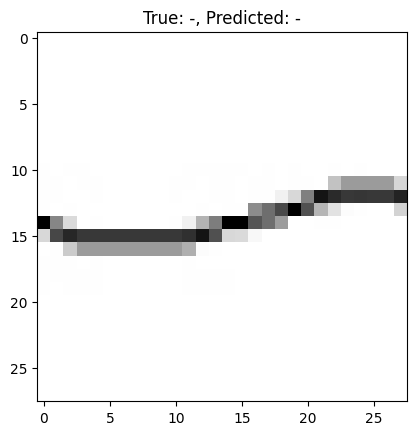

Prediction completed.
Starting image prediction...
Tensor saved to image_output.csv in matrix format.
Tensor saved to relu1_output.csv in matrix format.
Tensor saved to pool1_output.csv in matrix format.


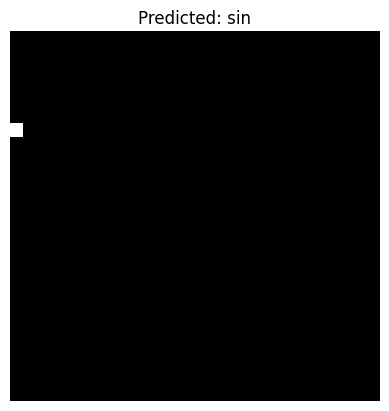

Prediction completed. Predicted character: sin


In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import csv
import torch.quantization as quant
import warnings
from PIL import Image

warnings.filterwarnings(
    "ignore",
    message=".*weights_only=False.*",  # Match the specific warning message
    category=FutureWarning
)

def save_tensor_to_csv_as_matrix(tensor, filename):
    """
    Save a PyTorch tensor to a CSV file, formatted as matrices for each channel.
    Each matrix represents the spatial dimensions (Height x Width) for a channel,
    with rows separated by commas.

    Parameters:
        tensor (torch.Tensor): The tensor to save (e.g., Batch x Channels x Height x Width).
        filename (str): The name of the CSV file to create.
    """
    # Handle quantized tensors
    if tensor.is_quantized:
        tensor = tensor.int_repr()  # Extract the integer representation

    # Convert the tensor to a NumPy array
    numpy_array = tensor.detach().cpu().numpy()

    # Ensure the tensor has 4 dimensions: [Batch, Channels, Height, Width]
    if len(numpy_array.shape) != 4:
        raise ValueError("Tensor must have 4 dimensions (Batch x Channels x Height x Width).")

    batch_size, num_channels, height, width = numpy_array.shape

    if batch_size != 1:
        raise ValueError("Only batch size of 1 is supported.")

    # Open the file and write matrices for each channel
    with open(filename, mode="w") as file:
        for channel in range(num_channels):
            file.write(f"Channel {channel + 1}:\n")  # Channel header
            for i, row in enumerate(numpy_array[0, channel]):  # Iterate over height (rows)
                file.write(f"{list(row)}")  # Format each row as a list
                if i < height - 1:
                    file.write(",\n")  # Add a comma between rows
                else:
                    file.write("\n")  # No comma after the last row
            file.write("\n")  # Add a newline between channels

    print(f"Tensor saved to {filename} in matrix format.")

class LeNet5(nn.Module):
    def __init__(self, num_classes=33):
        super(LeNet5, self).__init__()
        self.quant = torch.ao.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(120, 84)
        self.relu4 = nn.ReLU()
        self.fc3 = nn.Linear(84, num_classes)
        self.dequant = torch.ao.quantization.DeQuantStub()
        self.print_activation = False  # Add a flag to control printing

    def forward(self, x):
        x = self.quant(x)
        if self.print_activation:
            # print("quant output shape:", x)
            save_tensor_to_csv_as_matrix(x, "image_output.csv")
        x = self.conv1(x)
        x = self.relu1(x)
        if self.print_activation:
            # print("Conv1 output shape:", x.int_repr())
            save_tensor_to_csv_as_matrix(x, "relu1_output.csv")
        x = self.pool1(x)
        if self.print_activation:
            # print("Conv1 output shape:", x.int_repr())
            save_tensor_to_csv_as_matrix(x, "pool1_output.csv")
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = x.reshape(-1, 16 * 5 * 5)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.fc3(x)
        x = self.dequant(x)
        return x

def load_quantized_model_and_labels(model_path, num_classes, device):
    # Re-create the float model
    model = LeNet5(num_classes=num_classes)
    model.eval()

    # Set the same QAT configuration as before
    custom_qconfig = quant.QConfig(
        activation=quant.FakeQuantize.with_args(observer=quant.MinMaxObserver, quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine),
        weight=quant.FakeQuantize.with_args(observer=quant.MinMaxObserver, quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric)
    )

    # Apply the custom QConfig to the model
    model.qconfig = custom_qconfig

    # Fuse modules just like during training
    model_fused = torch.ao.quantization.fuse_modules(
        model,
        [['conv1', 'relu1'], ['conv2', 'relu2'], ['fc1', 'relu3'], ['fc2', 'relu4']]
    )

    # Prepare for QAT (simulates the same steps taken during training)
    model_prepared = torch.ao.quantization.prepare_qat(model_fused.train(), inplace=True)

    # Switch to eval mode before feeding dummy data
    model_prepared.eval()

    dummy_input = torch.randn(1, 1, 28, 28).to(device)
    with torch.no_grad():
        _ = model_prepared(dummy_input)  # Populates the observers

    # Now convert the model to quantized form after observers have data
    model_int8 = torch.ao.quantization.convert(model_prepared.eval())

    # Load the saved quantized model weights and labels
    checkpoint = torch.load(model_path, map_location=device)
    model_int8.load_state_dict(checkpoint['model_state_dict'])

    # Check if 'labels_mapping' exists in the checkpoint
    labels_mapping = checkpoint.get('labels_mapping', None)  # Default to None if key doesn't exist

    # Move to device and set to eval mode
    model_int8.to(device)
    model_int8.eval()

    if labels_mapping is not None:
        return model_int8, labels_mapping
    else:
        return model_int8, None

def predict_random_image(model, device, test_loader, int_to_char):
    model.eval()
    model.print_activation = True  # Enable printing before prediction
    print("Starting image prediction...")

    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images.to(device), labels.to(device)
    random_idx = random.randint(0, images.size(0) - 1)
    image = images[random_idx].unsqueeze(0)
    # print(image)
    true_label = labels[random_idx].item()

    with torch.no_grad():
        output = model(image)
        _, predicted_label = output.max(1)
        predicted_label = predicted_label.item()

    true_char = int_to_char[true_label]
    predicted_char = int_to_char[predicted_label]
    plt.imshow(image.squeeze().cpu().numpy(), cmap="gray")
    plt.title(f"True: {true_char}, Predicted: {predicted_char}")
    plt.show()

    print("Prediction completed.")
    model.print_activation = False  # Disable printing after prediction

def predict_specific_image(model, device, image_path, int_to_char):
    """
    Predicts the character from a given image path using the model.

    Args:
        model: The trained PyTorch model.
        device: The device (CPU or CUDA) on which the model is running.
        image_path: Path to the image file to be predicted.
        int_to_char: Dictionary mapping integer labels to characters.
    """
    model.eval()
    model.print_activation = True  # Enable printing before prediction
    print("Starting image prediction...")

    # Define the transform (must match the training transform)
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Ensure single channel
        transforms.Resize((28, 28)),                 # Resize to 28x28
        transforms.ToTensor(),                       # Convert to tensor
        transforms.Normalize((0.5,), (0.5,))         # Normalize to [-1, 1]
    ])

    # Load the image and apply transforms
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_label = output.max(1)
        predicted_label = predicted_label.item()

    # Convert label to character
    predicted_char = int_to_char[predicted_label]

    # Display the image with prediction
    plt.imshow(image_tensor.squeeze().cpu().numpy(), cmap="gray")
    plt.title(f"Predicted: {predicted_char}")
    plt.axis("off")
    plt.show()

    print(f"Prediction completed. Predicted character: {predicted_char}")
    model.print_activation = False


# Example usage (ensure you have defined test_loader and dataset.int_to_char):
model_path = "lenetV5.pth"  # Path to your saved quantized model
device = torch.device("cpu")
num_classes = 33  # Update with your number of classes

model_int8, labels  = load_quantized_model_and_labels(model_path, num_classes, device)
predict_random_image(model_int8, device, test_loader, int_to_char)

# image_path = "Untitled.png"  # Path to your image file
# predict_specific_image(model_int8, device, image_path, int_to_char)


In [11]:
# Retrieve the weights for the 'conv1' layer
conv1_weights = model_int8.state_dict()['conv1.weight'].int_repr()

# Print weights for each channel with separation
num_channels = conv1_weights.shape[0]  # Number of channels in conv1
for channel in range(num_channels):
    print(f'Channel {channel + 1} weights:')
    print(conv1_weights[channel].view(-1)[:25])  # Print the first 25 weights as an example
    print('-' * 50)  # Separator for clarity


Channel 1 weights:
tensor([ 40,  31,  55,  13,  53,  -1, -13, -46,  -4, -37, -29,  -3, -31,  26,
        -16,  -2, -21,  21, -54,  25,   3,  17,  12,  37, -13],
       dtype=torch.int8)
--------------------------------------------------
Channel 2 weights:
tensor([  -9,   48,   20,   54,  -16,   74,   72,   17,   34,  -11,  -15,   13,
          -3,  -18,   42,  -98,  -65,   13,  -37,    7,  -84, -127,  -31,   17,
          25], dtype=torch.int8)
--------------------------------------------------
Channel 3 weights:
tensor([-58, -52, -30,  -3, -28,  29,   4,  40,  -3,  36,  25,  32,  52, -43,
         -5,  26, -30,  25,  42, -34,  46,  57,   1,  30,  38],
       dtype=torch.int8)
--------------------------------------------------
Channel 4 weights:
tensor([ 29,  37,  53,  32,  -6,  46, -41,  52, -13, -41, -40, -11,  68, -38,
         -4, -11, -51,  -3, -78, -56,  -9, -33,  21,  -9,  20],
       dtype=torch.int8)
--------------------------------------------------
Channel 5 weights:
tensor(